# Semi-Supervised

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import os
import sys

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

import tensorflow as tf
import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

# Data 확인

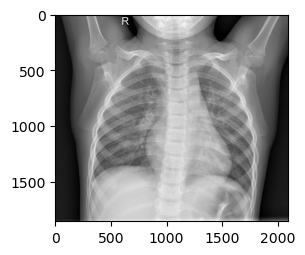

In [3]:
root_dir = './train/NORMAL'

plt.figure(figsize=(3, 3))
plt.imshow(Image.open(os.path.join(root_dir, 'IM-0115-0001.jpeg')), cmap='gray')
plt.show()

# CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transforms):
        super().__init__()
        self.transforms = transforms
        self.data = list()

        for label, cls in enumerate(classes):
            cls_path = os.path.join(root_dir, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                self.data.append((os.path.join(cls_path, img), label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.transforms(Image.open(self.data[idx][0]).convert('L'))
        label = self.data[idx][1]

        return img, label

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224))
])

classes = ['NORMAL', 'PNEUMONIA']

train_dataset = CustomDataset('./train', classes, transforms)
test_dataset = CustomDataset('./test', classes, transforms)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


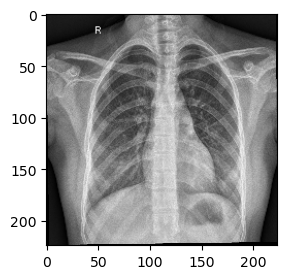

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(np.array(train_dataset[0][0].squeeze()), cmap='gray')
plt.show()

In [7]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=224*224, out_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=2048, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=256),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=128, out_features=32)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=32, out_features=128),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=128, out_features=256),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=256, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=2048, out_features=224*224),
        )

    def forward(self, x):
        x = x.view(-1, 224*224) # x.view(1, 224*224)를 쓰면 batch size가 있는 경우 연산이 불가능하다.
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [9]:
ae_model = Autoencoder()

summary(ae_model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]     102,762,496
              ReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 32]           4,128
           Linear-12                  [-1, 128]           4,224
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [10]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=8),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=112*112*32, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=2),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 1, 224, 224)
        output = self.layer(x)
        
        return output

In [11]:
clf_model = Classifier()
summary(clf_model, input_size=(1, 224*224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]              80
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           1,168
       BatchNorm2d-6         [-1, 16, 224, 224]              32
              ReLU-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 224, 224]               0
            Conv2d-9         [-1, 32, 224, 224]           4,640
      BatchNorm2d-10         [-1, 32, 224, 224]              64
             ReLU-11         [-1, 32, 224, 224]               0
        MaxPool2d-12         [-1, 32, 112, 112]               0
          Flatten-13               [-1, 401408]               0
           Linear-14                 [-

# train

In [12]:
def ae_training(model, train_dataloader, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 224*224)
        encoded, decoded = model(images)
        loss = criterion(decoded, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
        tbar.set_description(f'Epoch/Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)

    return model, train_loss

def ae_training_loop(model, train_dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss = ae_training(model, train_dataloader, criterion, optimizer, epoch, num_epochs)

        print(train_loss)
        
    return model

In [13]:
def clf_training(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        encoded, decoded = ae_model(images)
        outputs = model(decoded)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (labels == predicted).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def clf_training_loop(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = clf_training(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)

        print(f'Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f}')

    return model

In [14]:
ae_model = Autoencoder()
ae_criterion = torch.nn.MSELoss()
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

ae_model = ae_training_loop(ae_model, train_dataloader, ae_criterion, ae_optimizer, 15)

  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0472, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0181, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0173, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0158, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0156, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0156, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0151, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0152, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0151, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0152, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0152, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0149, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0184, grad_fn=<DivBackward0>)


  0%|          | 0/164 [00:00<?, ?it/s]

tensor(0.0176, grad_fn=<DivBackward0>)


In [15]:
for images, labels in test_dataloader:
    encoded, decoded = ae_model(images)
    break

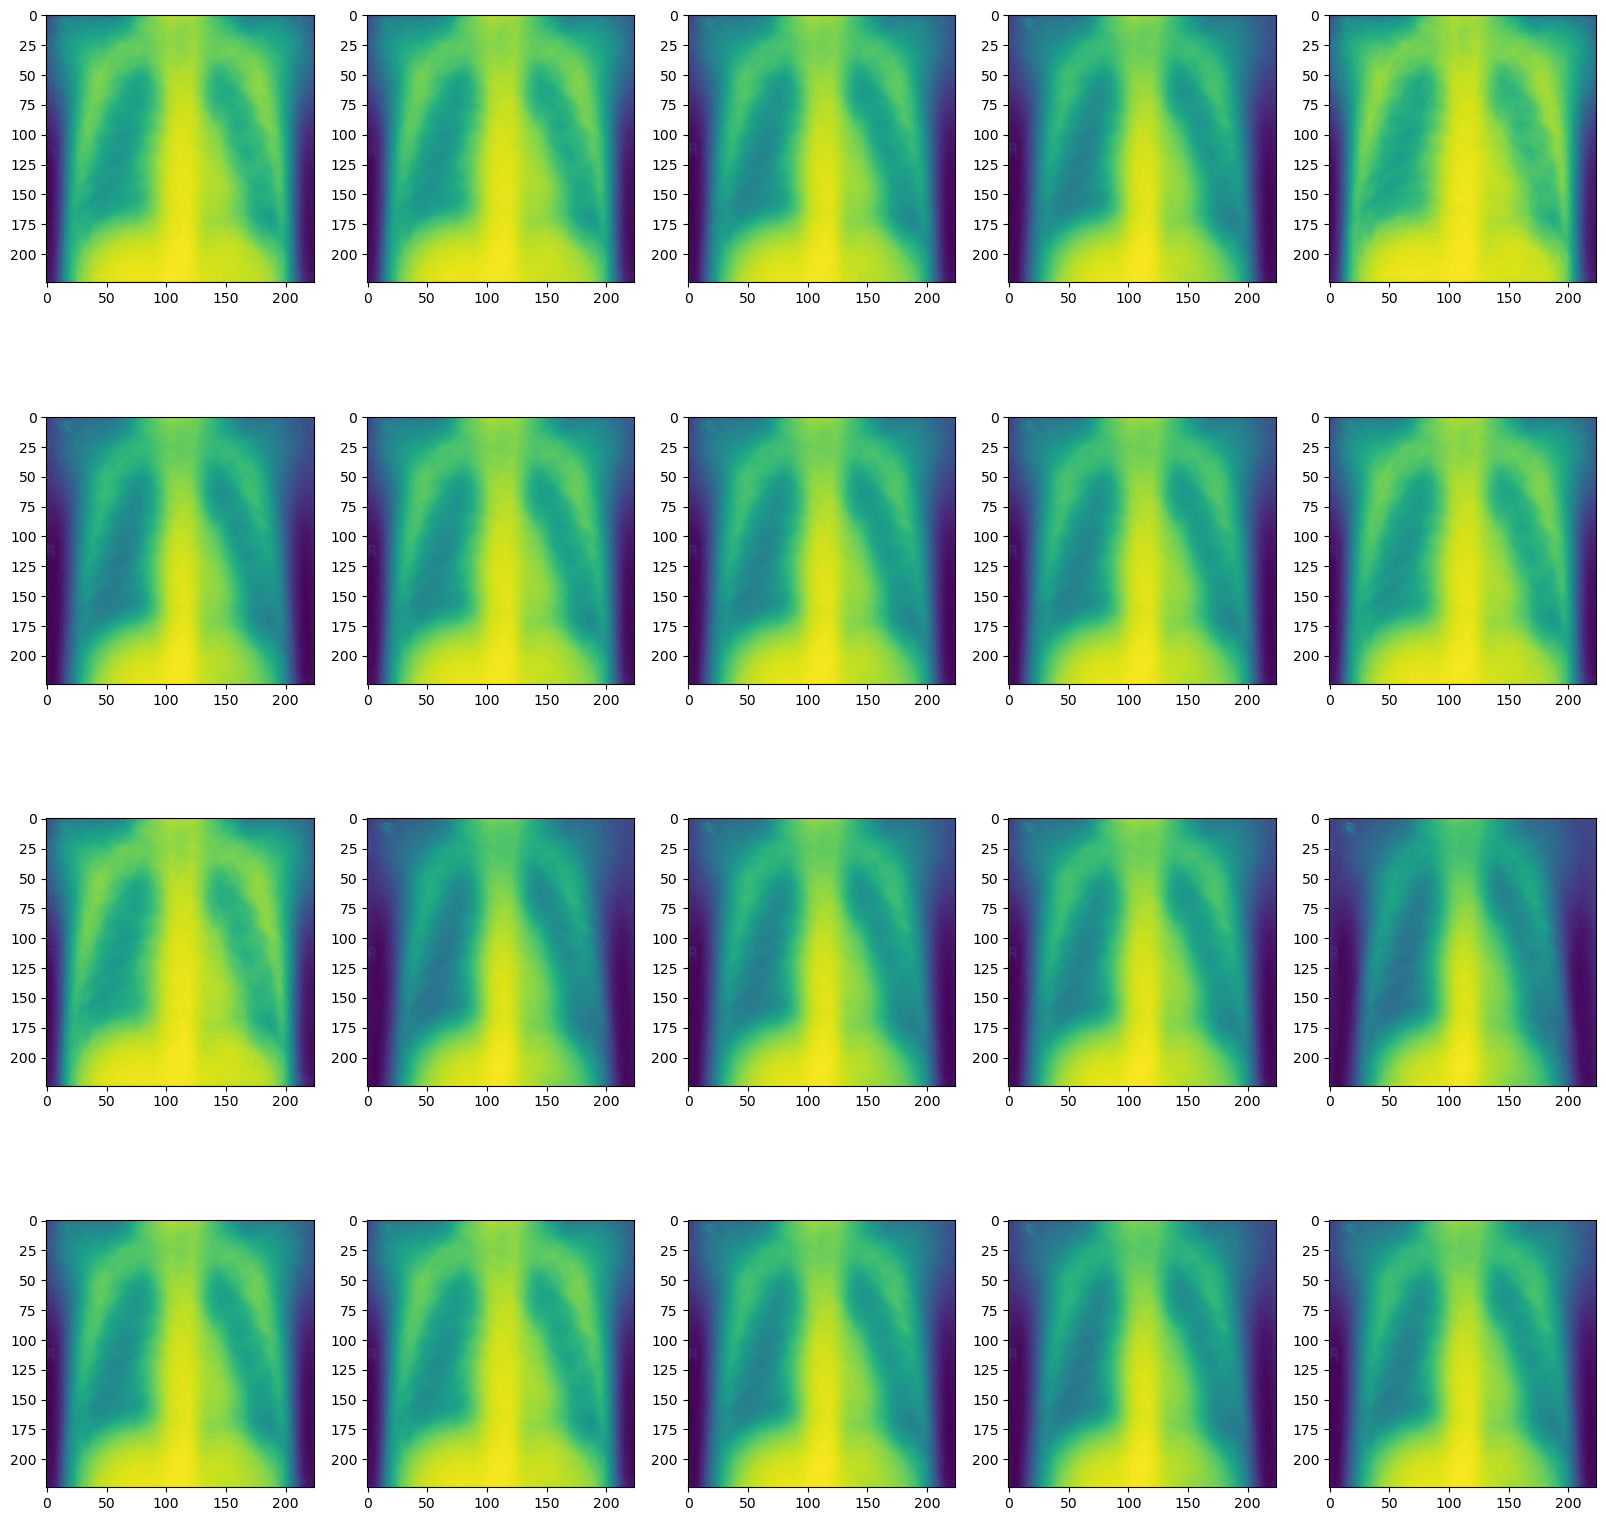

In [16]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(decoded[i].view(224, 224).detach().numpy())

In [17]:
torch.save(ae_model.state_dict(), './ae_model.pt')

In [17]:
clf_model = Classifier()
clf_criterion = torch.nn.NLLLoss()
clf_optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)

clf_model = clf_training_loop(clf_model, ae_model, train_dataloader, train_dataset, clf_criterion, clf_optimizer, 1)

  0%|          | 0/164 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 2.3636 Train Accuracy: 0.8700


In [20]:
torch.save(clf_model.state_dict(), './clf_model.pt')